# LDCT Inv model

## Testing the implementation

In [1]:
from ldctinv.vae.blocks import ActNorm, GBlock, SelfAttention, SpectralNorm, DenseEncoderLayer
import torch.nn.functional as F
from torch.nn import BatchNorm2d
import torch.nn as nn
import torch
import math
from torchvision import models
from ldctinv.utils.distributions import DiagonalGaussianDistribution

class Generator(nn.Module):
    def __init__(
        self,
        code_dim,
        z_dim,
        im_ch,
        n_class,
        chn,
        use_actnorm,
        cond_ch,
        output_size=128,
        latimage=False,
    ):
        super().__init__()

        self.latimage = latimage
        self.z_dim = z_dim
        self.output_size = output_size
        if not latimage:
            self.num_layers = int(math.log2(output_size)) - 2
        else:
            self.num_layers = 5 # number of downsampling layers in ResNet50
        self.init_side_length = self.output_size // (2**(self.num_layers-latimage))
        if latimage and z_dim % (self.init_side_length)**2 != 0:
            raise ValueError(f"z_dim must be divisible by latent resolution**2 {(self.init_side_length**2)} when latimage=True")

        
        self.sa_id = self.num_layers - 2
        self.num_split = self.num_layers + 1
        self.linear = nn.Linear(n_class, 2*(self.init_side_length**2), bias=False)

        if self.latimage:
            split_size = 1
            self.first_view = z_dim // (self.init_side_length**2) - (self.num_split - 1) * split_size
            first_split = self.first_view
        else:
            split_size = 20
            self.first_view = (output_size // 8) ** 2 * chn
            first_split = z_dim - (self.num_split - 1) * split_size
            self.G_linear = SpectralNorm(nn.Linear(first_split, self.first_view))

        self.split_at = [first_split] + [split_size for _ in range(self.num_split - 1)]

        G_block_z_dim = 3 if self.latimage else code_dim + 28
        first_chn = (
            first_split
            if self.latimage
            else self.first_view // (self.output_size // (2**self.num_layers)) ** 2
        )

        channels = [first_chn] + [
            chn * (2**i) for i in range(self.num_layers - 1, -1, -1)
        ]
        print(channels)
        self.GBlock = nn.ModuleList(
            [
                GBlock(
                    channels[i] + cond_ch,
                    channels[i + 1],
                    n_class=n_class,
                    z_dim=G_block_z_dim,
                    upsample=(not self.latimage) or i > 0,
                    latimage=self.latimage,
                )
                for i in range(self.num_layers)
            ]
        )

        self.attention = SelfAttention(channels[self.sa_id])
        self.ScaledCrossReplicaBN = (
            BatchNorm2d(channels[-1], eps=1e-4)
            if not use_actnorm
            else ActNorm(channels[-1])
        )
        self.colorize = nn.Conv2d(
            channels[-1] + cond_ch, im_ch, kernel_size=3, padding=1
        )

    def forward(self, input, class_id, im_cond=None):

        if self.latimage:
            input = input.view(-1, self.z_dim // (self.init_side_length**2), self.init_side_length, self.init_side_length)
            
        codes = torch.split(input, self.split_at, 1)
        class_emb = self.linear(class_id)

        if not self.latimage:
            out = self.G_linear(codes[0])
            out = out.view(
                -1, self.init_side_length, self.init_side_length, self.first_view // (self.init_side_length**2)
            ).permute(0, 3, 1, 2)
        else:
            class_emb = class_emb.view(-1, 2, self.init_side_length, self.init_side_length)
            out = codes[0]

        for i, (code, GBlock) in enumerate(zip(codes[1:], self.GBlock)):
            if i == self.sa_id:
                out = self.attention(out)
            condition = torch.cat([code, class_emb], 1)
            if i > 1 and self.latimage:
                condition = F.interpolate(condition, scale_factor=2 ** (i - 1))
            if im_cond is not None:
                scale_factor = 1 / 2 ** (self.num_layers - i)
                if self.latimage and i==0:
                    scale_factor = 1 / 2 ** (self.num_layers - i - 1)
                im_cond_rescaled = F.interpolate(im_cond, scale_factor=scale_factor)
                out = torch.cat([out, im_cond_rescaled], 1)
            out = GBlock(out, condition)

        out = self.ScaledCrossReplicaBN(out)
        if im_cond is not None:
            out = torch.cat([out, im_cond], 1)
        out = self.colorize(out)
        return out

    def encode(self, *args, **kwargs):
        raise RuntimeError("BigGAN architecture does not have an encoder")

    def decode(self, z, cls):
        z = z.float()
        cls_one_hot = torch.nn.functional.one_hot(cls, num_classes=1000).float()
        return self.forward(z, cls_one_hot)

_norm_options = {"in": nn.InstanceNorm2d, "bn": nn.BatchNorm2d, "an": ActNorm}

class ResnetEncoder(nn.Module):
    def __init__(self, in_ch, z_dim, input_size, norm, net_type="resnet50", pretrained=False, latimage=False):
        super().__init__()
        self.latimage = latimage
        __possible_resnets = {
            "resnet18": models.resnet18,
            "resnet34": models.resnet34,
            "resnet50": models.resnet50,
            "resnet101": models.resnet101,
        }
        __possible_weights = {
            "resnet18": models.ResNet18_Weights.IMAGENET1K_V1,
            "resnet34": models.ResNet34_Weights.IMAGENET1K_V1,
            "resnet50": models.ResNet50_Weights.IMAGENET1K_V1,
            "resnet101": models.ResNet101_Weights.IMAGENET1K_V1,
        }
        z_dim = self.z_dim = z_dim
        ipt_size = input_size
        self.input_size = [in_ch, ipt_size, ipt_size]
        norm_layer = _norm_options[norm]
        self.z_dim = z_dim
        if pretrained and norm != "bn":
            warnings.warn(
                f"If pretrained, then args.norm must be bn! Got pretrained={pretrained} but norm_layer={norm}. Using bn for ResNet instead!"
            )
            norm_layer = _norm_options["bn"]
        self.model = __possible_resnets[net_type](
            weights=__possible_weights[net_type] if pretrained else None, norm_layer=norm_layer
        )

        # replace first conv
        self.model.conv1 = nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
        #self.model.conv1 = nn.Conv2d(in_ch, 64, kernel_size=3, stride=2, padding=1, bias=False)
        #self.model.maxpool_n = nn.MaxPool2d(kernel_size=8)

        size_pre_fc = self._get_spatial_size()
        assert size_pre_fc[2] == size_pre_fc[3], "Output spatial size is not quadratic"
        spatial_size = size_pre_fc[2]
        num_channels_pre_fc = size_pre_fc[1]
        print("spatial size: ", spatial_size)
        print("num_channels_pre_fc: ", num_channels_pre_fc)

        if not self.latimage:
            # replace last fc
            self.model.fc = DenseEncoderLayer(
                0, spatial_size=spatial_size, out_size=2 * z_dim, in_channels=num_channels_pre_fc
            )
        else:
            assert z_dim%(spatial_size**2)==0, f"z_dim has to be a multiple of {spatial_size**2}"
            self.model.mu_layer = nn.Conv2d(num_channels_pre_fc, z_dim//(spatial_size**2), kernel_size=1)
            #self.model.logvar_layer = nn.Conv2d(num_channels_pre_fc, z_dim//(spatial_size**2), kernel_size=1)
            self.model.flatten = nn.Flatten()

    def forward(self, x):
        #x[:,0] = x[:,0] - x[:,1]
        features = self.features(x)
        encoding = self.post_features(features)

        return encoding

    def features(self, x):
        x = self.model.conv1(x)
        #x_n = self.model.maxpool_n(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        #if self.latimage:
        #    x = torch.cat([x,x_n], dim=1)
        if not self.latimage:
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
        return x

    def post_features(self, x):
        if not self.latimage:
            x = self.model.fc(x)
        else:
            mu = self.model.mu_layer(x)
            #logvar = self.model.logvar_layer(x)
            logvar = torch.zeros_like(mu)
            x = torch.cat((self.model.flatten(mu), self.model.flatten(logvar)), dim=1).unsqueeze(-1).unsqueeze(-1)
        return x

    def _get_spatial_size(self):
        x = torch.randn(1, *self.input_size)
        return self.features(x).size()

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [4]:
g = Generator(code_dim=120, z_dim=49*64, im_ch=1, n_class=1000, chn=96, use_actnorm=True, cond_ch=1, output_size=224, latimage=True).to(device)

[11, 1536, 768, 384, 192, 96]


In [5]:
x_in = torch.randn(5, 49*64).to(device)
class_in = torch.randn(5, 1000).to(device)
im_cond = torch.randn(5, 1, 224, 224).to(device)
out = g(x_in, class_in, im_cond=im_cond)
print(out.shape)

torch.Size([5, 1, 224, 224])


In [6]:
r = ResnetEncoder(in_ch=2, z_dim=49*64, input_size=224, norm="bn", net_type="resnet50", pretrained=True, latimage=True).to(device)

spatial size:  14
num_channels_pre_fc:  1024


In [7]:
im_in = torch.randn(5, 1, 224, 224).to(device)
im_cond = torch.randn(5, 1, 224, 224).to(device)
with torch.no_grad():
    out = r(torch.cat((im_in, im_cond), dim=1))
    print("mu + logvar shape:", out.shape)
    z = DiagonalGaussianDistribution(out, deterministic=False).sample()
    print("z shape: ", z.shape)
    rec = g(z, class_in, im_cond=im_cond)
    print("rec shape: ", rec.shape)

mu + logvar shape: torch.Size([5, 6272, 1, 1])
z shape:  torch.Size([5, 3136, 1, 1])
rec shape:  torch.Size([5, 1, 224, 224])


## Model plotting

In [23]:
from fff import FiberModel
import os
import torch 
device = "cuda" if torch.cuda.is_available() else "cpu"

model_folder = "/home/armand/helix_store/fiberlearning/lightning_logs/version_200/"
# model_folder = "/home/armand/PhD/FFF_fiberlearning/lightning_logs/version_4/"

hparams_path = os.path.join(model_folder, "hparams.yaml")
checkpoint_path = os.path.join(model_folder, "checkpoints/last.ckpt")
# checkpoint_path = os.path.join(model_folder, "checkpoints/epoch=5-step=144.ckpt")

ckpt = torch.load(checkpoint_path, map_location=torch.device("cpu"))  # Load on CPU
hparams = ckpt["hyper_parameters"]
hparams["data_set"]["root"] = "/mnt/SSD_2TB/ldct_data"
hparams["data_set"]["subject_model_path"] = "../notebooks/SubjectModels/saved_models/BiomedClip.pt"
if hparams.get("load_lossless_ae_path") is None and "LDCTInvModel" in hparams["lossless_ae"]["model_spec"][0]['name']:
    hparams["lossless_ae"]["model_spec"][0]['latent_dim'] //= 2
hparams["lossless_ae"]["cond_embedding_network"][1]["normalize"] = True
hparams["load_lossless_ae_path"] = None
hparams["ae_deterministic_encode"] = False


model = FiberModel(hparams)
model.load_state_dict(ckpt["state_dict"])
model.eval()
model.to(device)
pass

/tmp/ipykernel_3679407/962402327.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=torch.device("cpu"))  # Load on CPU


loading subject_model
cond_dim:  0
output_dim:  512
spatial size:  14
num_channels_pre_fc:  1024
cond_dim:  0
output_dim:  512


/home/armand/miniconda3/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/100 [00:00<?, ?it/s]

Loss before refinement: 0.007406363729387522, after refinement: 0.0001375656429445371


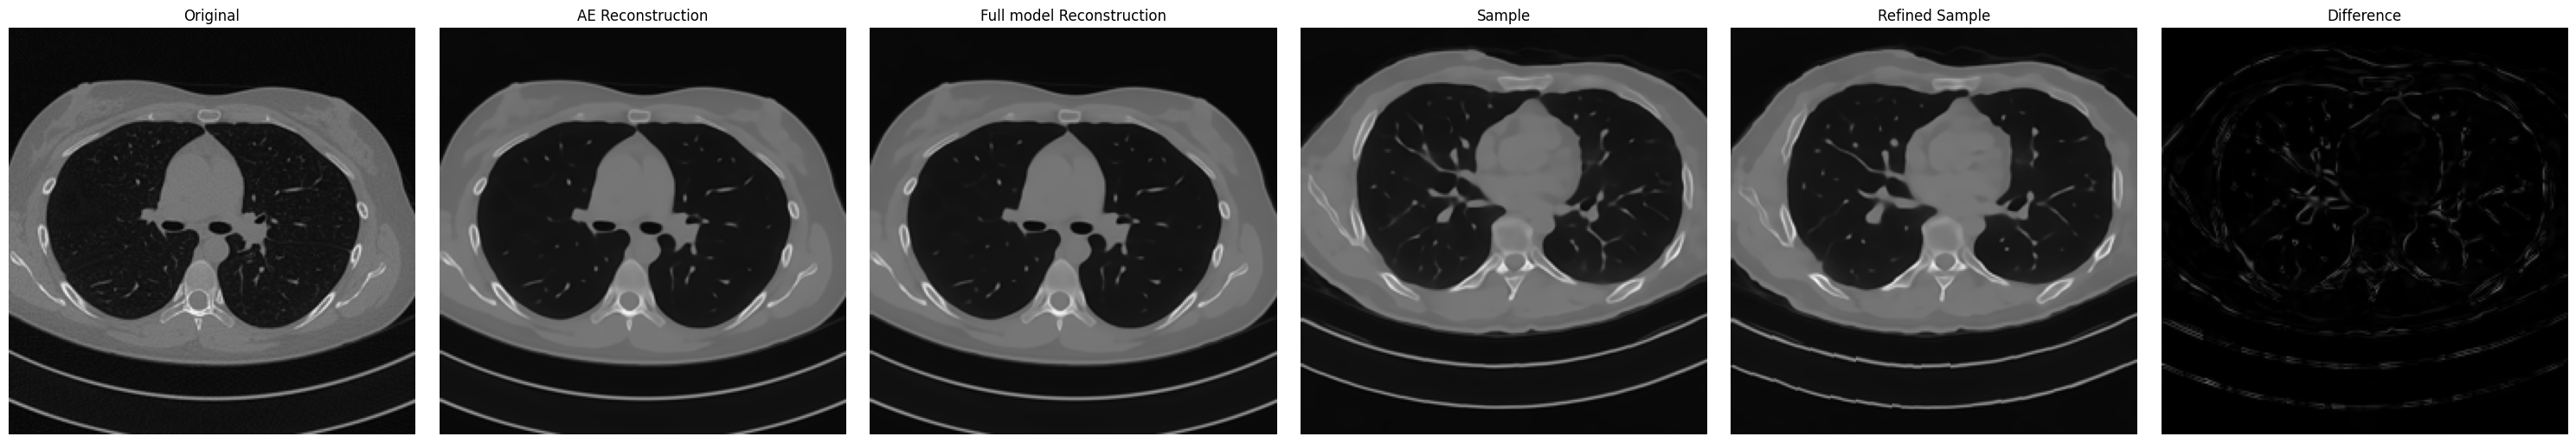

In [28]:
import matplotlib.pyplot as plt
import torch
from math import prod
from tqdm.auto import tqdm, trange

device = "cuda" if torch.cuda.is_available() else "cpu"
n_samples = 1
n_plots = 3+3*n_samples

@torch.no_grad()
def sample_with_latent_contraction(model, sample_shape, condition=None, scaling_factor=1.0, **kwargs):
    try:
        z_dense = model.get_latent(model.device).sample(sample_shape, condition)
    except TypeError:
        z_dense = model.get_latent(model.device).sample(sample_shape)
    z_dense = z_dense.reshape(
        prod(sample_shape), *z_dense.shape[len(sample_shape) :]
    ) * scaling_factor
    batch = [z_dense]
    if condition is not None:
        c = condition
    else:
        c = torch.empty(z_dense.shape[0], 0).to(z_dense.device)
    z = model.sample_density(z_dense, c, **kwargs)
    x = model.decode_lossless(z, c)
    return x.reshape(sample_shape + x.shape[1:])

@torch.enable_grad()
def refine_with_gradient_descent(samples, originals, conditions, model, steps=25, lr=0.01):
    subject_model = model.subject_model
    samples = samples.clone().requires_grad_(True).to(device)
    optimizer = torch.optim.Adam([samples], lr=lr)
    original_embeddings = subject_model.encode(originals.to(device)).detach()
    criterion = torch.nn.MSELoss(reduce="mean")
    subject_model.eval()
    loss_start = 0.0
    loss_end = 0.0
    
    for i in trange(steps):
        optimizer.zero_grad()
        loss = criterion(subject_model.encode(samples), original_embeddings)
        if i == 0:
            loss_start = torch.sqrt(loss).item()
        if i == steps - 1:
            loss_end = torch.sqrt(loss).item()
        loss.backward()
        optimizer.step()

    print(f"Loss before refinement: {loss_start}, after refinement: {loss_end}")
    return samples.detach()

@torch.enable_grad()
def refine_in_ae_latent_space(samples, originals, conditions, model, steps=25, lr=0.01):
    with torch.no_grad():
        z_samples = model.encode_lossless(samples.to(device), conditions).detach()
    z_samples = z_samples.clone().requires_grad_(True).to(device)
    optimizer = torch.optim.Adam([z_samples], lr=lr)
    original_embeddings = model.subject_model.encode(originals.to(device)).detach()
    criterion = torch.nn.MSELoss(reduce="mean")
    loss_start = 0.0
    loss_end = 0.0
    
    for i in trange(steps):
        optimizer.zero_grad()
        decoded = model.decode_lossless(z_samples, conditions)
        loss = criterion(model.subject_model.encode(decoded), original_embeddings)
        if i == 0:
            loss_start = torch.sqrt(loss).item()
        if i == steps - 1:
            loss_end = torch.sqrt(loss).item()
        loss.backward()
        optimizer.step()

    print(f"Loss before refinement: {loss_start}, after refinement: {loss_end}")
    return model.decode_lossless(z_samples, conditions).detach().reshape(samples.shape)

with torch.no_grad():
    batch = model.val_data[0]
    resolution = hparams["data_set"].get("resize_to", 128)
    batch = (batch[0].unsqueeze(0).to(device), batch[1].unsqueeze(0).to(device))
    conditioned = model.apply_conditions(batch)
    c = conditioned.condition.to(device)
    x0 = conditioned.x0.to(device)

    x_rec_ae = model.decode_lossless(model.encode_lossless(x0, c, return_only_x=True), c)
    x_rec_ae = x_rec_ae.squeeze(0).reshape(1, resolution, resolution)

    if not model.density_model_type in ["diffusion"]:
        x_rec = model(x0, c)
        x_rec = x_rec.squeeze(0).reshape(1, resolution, resolution)
    else:
        x_rec = x_rec_ae
        
    if model.hparams.cfg:
        samples = model.sample(torch.Size([n_samples]), 
                               condition=c.repeat(n_samples, 1), 
                               guidance_scale=2.0).reshape(n_samples, 1, resolution, resolution)
    else:
        samples = sample_with_latent_contraction(model, 
                                                 torch.Size([n_samples]), 
                                                 condition=c.repeat(n_samples, 1), 
                                                 scaling_factor=1.0).reshape(n_samples, 1, resolution, resolution)
    refined_samples = refine_in_ae_latent_space(samples, 
                                                   x0,
                                                   c,
                                                   model, 
                                                   steps=100, lr=0.02)
    plt.figure(figsize=(n_plots*5, 5))
    plt.subplot(1, n_plots, 1)
    # save color range:
    vmin = x0.min().item()
    vmax = x0.max().item()
    plt.imshow(x0.reshape(resolution, resolution).cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Original")
    plt.axis("off")
    plt.subplot(1, n_plots, 2)
    plt.imshow(x_rec_ae.squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title("AE Reconstruction")
    plt.subplot(1, n_plots, 3)
    plt.imshow(x_rec.squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title("Full model Reconstruction")
    for i in range(n_samples):
        plt.subplot(1, n_plots, 4+i*3)
        plt.imshow(samples[i].squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
        plt.axis("off")
        plt.title("Sample")
        plt.subplot(1, n_plots, 4+i*3+1)
        plt.imshow(refined_samples[i].squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
        plt.axis("off")
        plt.title("Refined Sample")
        plt.subplot(1, n_plots, 4+i*3+2)
        plt.imshow(torch.abs(samples[i] - refined_samples[i]).squeeze().cpu().numpy(), cmap="gray", vmin=0, vmax=(vmax-vmin))
        plt.axis("off")
        plt.title("Difference")
    plt.tight_layout()
    plt.show()

In [31]:
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_latent(model, data_loader, max_batches=10):
    latent_ae = []
    latent = []
    latent_ae_sampled = []
    
    for i, batch in enumerate(data_loader):
        if i >= max_batches:
            break
        batch = (batch[0].to(device), batch[1].to(device))
        conditioned = model.apply_conditions(batch)
        c = conditioned.condition.to(device)
        x0 = conditioned.x0.to(device)
        z_ae = model.encode_lossless(x0, c, return_only_x=True)
        if model.density_model_type in ["diffusion"]:
            z = torch.randn_like(z_ae)
        else:
            z = model.encode_density(z_ae, c)
            z_ae_recon = model.decode_density(z, c)
            recon_error = torch.sqrt(torch.mean((z_ae - z_ae_recon)**2, dim=1))
            print(f"{recon_error.mean()} +- {recon_error.std()}")
        z_ae = z_ae.view(z_ae.shape[0], -1)
        z = z.view(z.shape[0], -1)
        z_sampled = model.sample_density(torch.randn_like(z), c)
        latent_ae.append(z_ae)
        latent.append(z)
        latent_ae_sampled.append(z_sampled)
    latent_ae = torch.cat(latent_ae, dim=0)
    latent = torch.cat(latent, dim=0)
    latent_ae_sampled = torch.cat(latent_ae_sampled, dim=0)
    print(latent_ae.shape, latent.shape, latent_ae_sampled.shape)
    plt.figure(figsize=(12, 15))
    plt.subplot(3, 3, 1)
    # plot reference gaussian
    x = torch.linspace(-3, 3, 100)
    y = torch.linspace(-3, 3, 100)
    X, Y = torch.meshgrid(x, y)
    Z = torch.exp(-X**2 - Y**2)
    plt.scatter(latent_ae[:, 0].cpu().numpy(), latent_ae[:, 1].cpu().numpy(), s=1)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.contour(X, Y, Z, levels=10, colors="red", alpha=0.3)
    plt.title("Latent AE, first two coords")
    plt.subplot(3, 3, 2)
    plt.scatter(latent[:, 0].cpu().numpy(), latent[:, 1].cpu().numpy(), s=1)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.contour(X, Y, Z, levels=10, colors="red", alpha=0.3)
    plt.title("Latent density, first two coords")
    plt.subplot(3, 3, 3)
    plt.scatter(latent_ae_sampled[:, 0].cpu().numpy(), latent_ae_sampled[:, 1].cpu().numpy(), s=1)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.contour(X, Y, Z, levels=10, colors="red", alpha=0.3)
    plt.title("Sampled AE latent, first two coords")
    plt.subplot(3, 3, 4)
    latent_ae_mean = latent_ae.mean(dim=0)
    plt.hist(latent_ae_mean.cpu().numpy(), range=[-2, 2], bins=50)
    plt.title("Latent AE mean")
    plt.subplot(3, 3, 5)
    latent_mean = latent.mean(dim=0)
    plt.hist(latent_mean.cpu().numpy(), range=[-2, 2], bins=50)
    plt.title("Latent density mean")
    plt.subplot(3, 3, 6)
    latent_mean = latent_ae_sampled.mean(dim=0)
    plt.hist(latent_mean.cpu().numpy(), range=[-2, 2], bins=50)
    plt.title("Sampled AE latent mean")
    plt.subplot(3, 3, 7)
    latent_ae_std = latent_ae.std(dim=0)
    plt.hist(latent_ae_std.cpu().numpy(), range=[0, 5], bins=50)
    plt.title("Latent AE std")
    plt.subplot(3, 3, 8)
    latent_std = latent.std(dim=0)
    plt.hist(latent_std.cpu().numpy(), range=[0, 5], bins=50)
    plt.title("Latent density std")
    plt.subplot(3, 3, 9)
    latent_std = latent_ae_sampled.std(dim=0)
    plt.hist(latent_std.cpu().numpy(), range=[0, 5], bins=50)
    plt.title("Sampled AE latent std")
    plt.show()
    plt.close()
    x_recon = model.decode_lossless(z_ae_recon[-1:], c[-1:])
    x_ae_recon = model.decode_lossless(z_ae[-1:], c[-1:])
    x_recon = (x_recon - x_ae_recon).reshape(1, 224, 224)
    print(torch.sqrt((x_recon**2).mean()), torch.sqrt(((z_ae_recon[-1:] - z_ae[-1:])**2).mean()))
    plt.imshow(x_recon.squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Full model Reconstruction")
    plt.show()

In [32]:
print(c.shape)

torch.Size([1, 512])


0.36280494928359985 +- 0.06473096460103989
0.362626314163208 +- 0.06953004002571106
0.3723505139350891 +- 0.07328526675701141
0.36965811252593994 +- 0.05676674842834473
0.37062785029411316 +- 0.06698855757713318
0.3629871904850006 +- 0.06346242874860764
0.37521427869796753 +- 0.06316768378019333
0.3721693754196167 +- 0.06448648869991302
0.3712806701660156 +- 0.0696796253323555
0.3787762522697449 +- 0.0740879699587822
torch.Size([640, 3920]) torch.Size([640, 1000]) torch.Size([640, 3920])


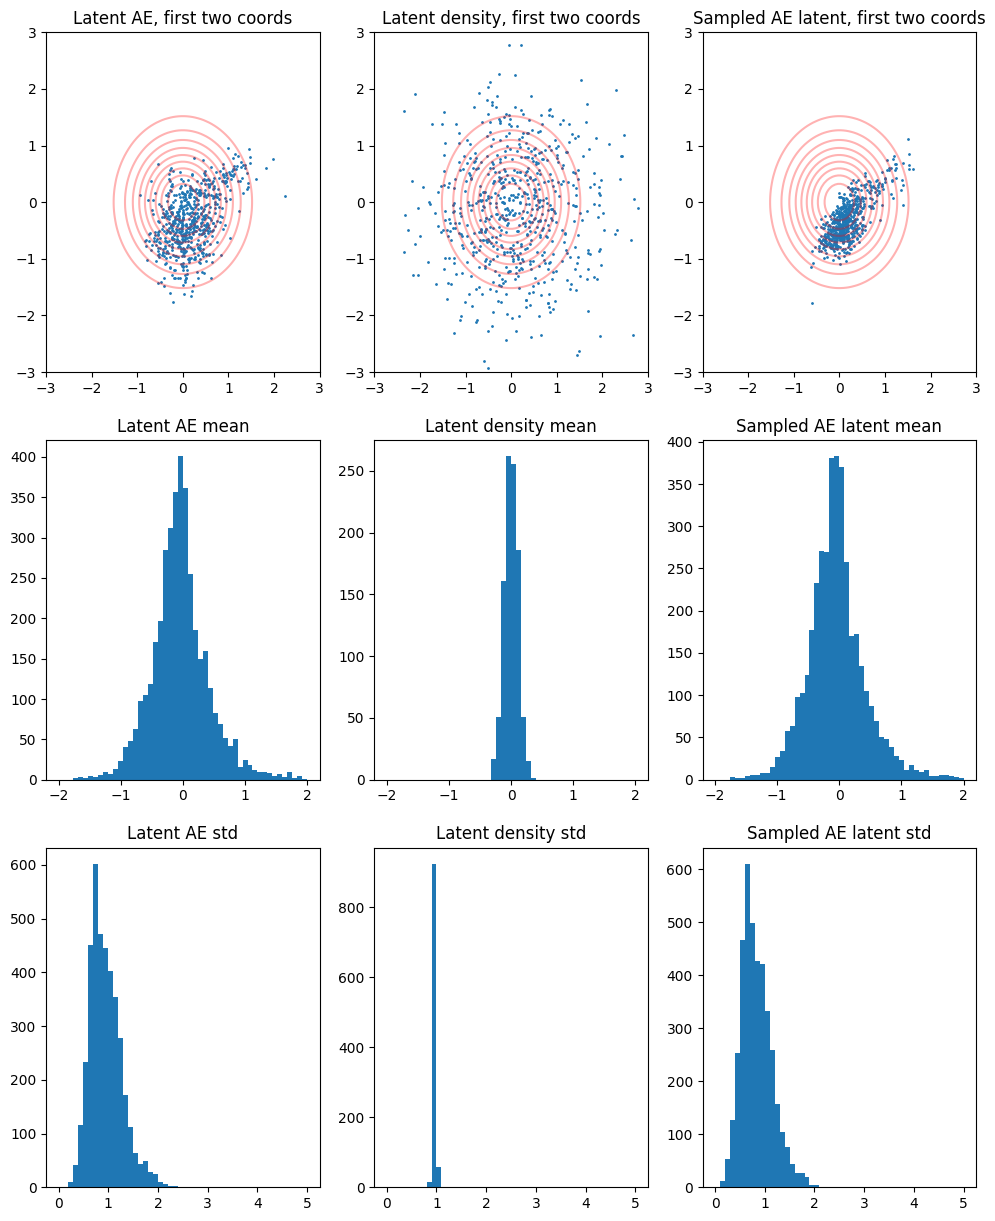

tensor(0.2589, device='cuda:0') tensor(0.3788, device='cuda:0')


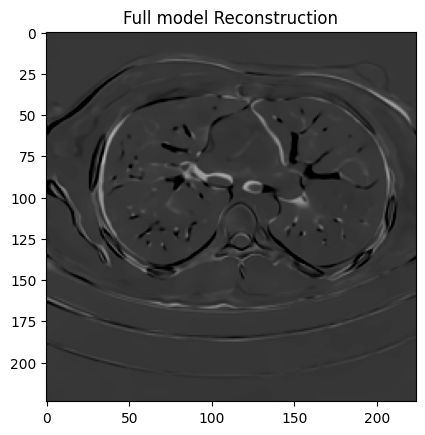

In [33]:
plot_latent(model, model.train_dataloader(), max_batches=10)

0.6541866064071655 +- 0.15583115816116333
0.6412305235862732 +- 0.16415667533874512
0.6684525609016418 +- 0.1803847700357437
0.6760815978050232 +- 0.16447600722312927
0.640339732170105 +- 0.15236440300941467
0.6550116539001465 +- 0.15772108733654022
0.6375761032104492 +- 0.13106614351272583
0.6513950824737549 +- 0.17275679111480713
0.6752049922943115 +- 0.16863442957401276
0.6667360067367554 +- 0.17386005818843842
torch.Size([640, 3920]) torch.Size([640, 1000]) torch.Size([640, 3920])


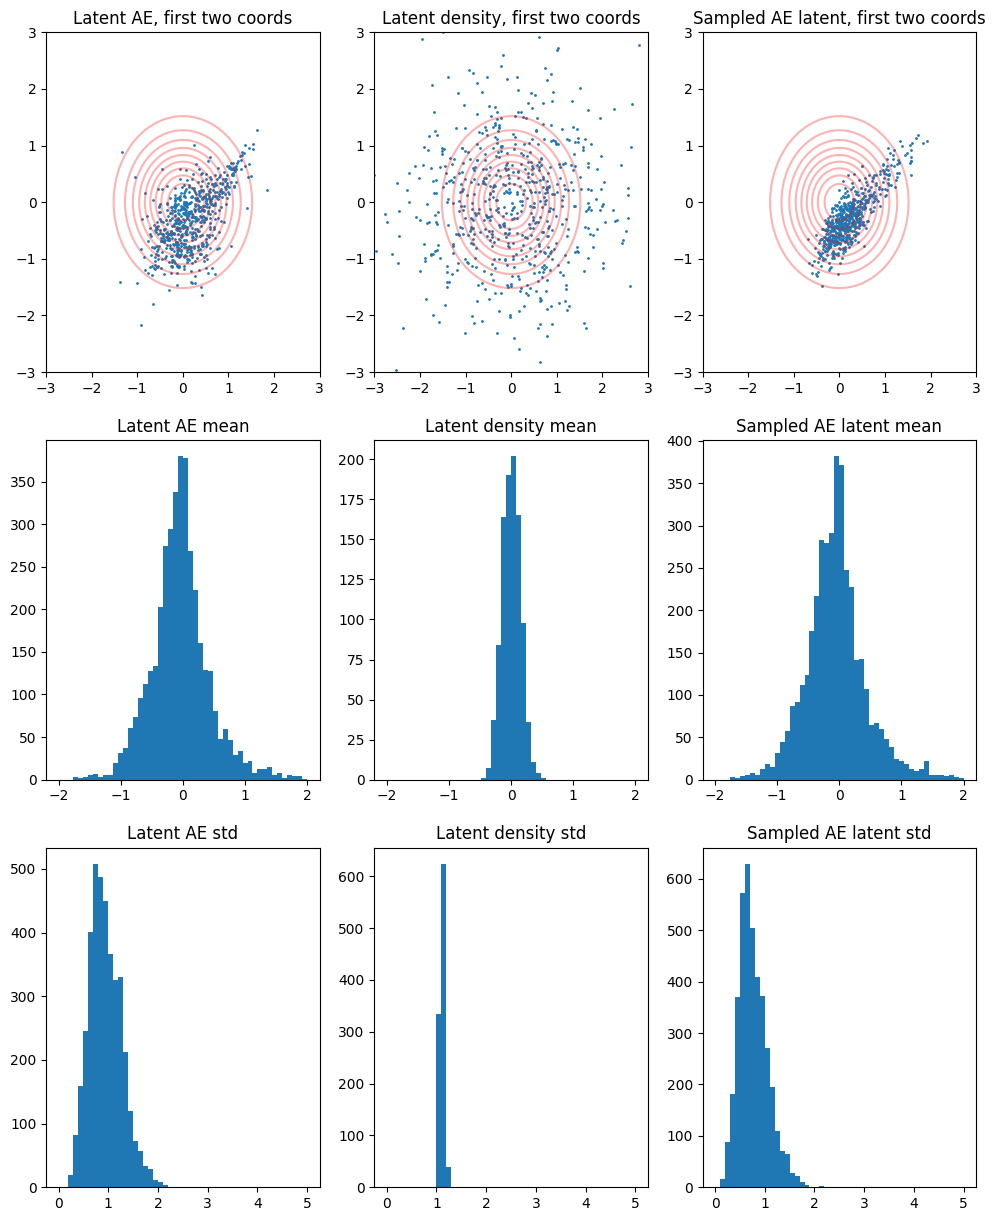

tensor(0.4784, device='cuda:0') tensor(0.6183, device='cuda:0')


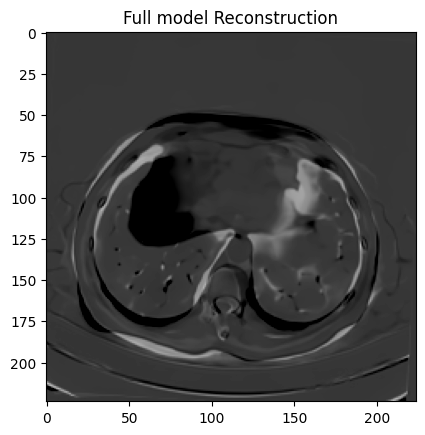

In [34]:
plot_latent(model, model.val_dataloader(), max_batches=10)

In [19]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

@torch.no_grad()
def get_fiber_loss(model, orig, fake):
    return torch.sqrt(torch.mean((model.subject_model.encode(orig) - model.subject_model.encode(fake))**2))

@torch.no_grad()
def fiber_loss_with_guidance(model, data_loader, max_batches=10, scales=[1.0, 1.5, 2.0, 3.0, 5.0]):
    fiber_losses = []
    n_batches = min(max_batches, len(data_loader))

    for i, scale in enumerate(tqdm(scales, position=0)):
        fiber_losses.append(0.0)
        for k, batch in enumerate(tqdm(data_loader, position=1, leave=False, total=n_batches)):
            if k >= max_batches:
                break
            batch = (batch[0].to(device), batch[1].to(device))
            conditioned = model.apply_conditions(batch)
            c = conditioned.condition.to(device)
            x0 = conditioned.x0.to(device)
            samples = model.sample(torch.Size([x0.shape[0]]), condition=c, guidance_scale=scale).reshape(x0.shape[0], 1, resolution, resolution)
            fiber_losses[i] += get_fiber_loss(model, x0, samples)
        fiber_losses[i] /= n_batches

    return scales, fiber_losses

@torch.no_grad()
def fiber_loss_without_guidance(model, data_loader, max_batches=10):
    n_batches = min(max_batches, len(data_loader))

    fiber_loss = 0.0
    for k, batch in enumerate(tqdm(data_loader, position=0, leave=True, total=n_batches)):
        if k >= max_batches:
            break
        batch = (batch[0].to(device), batch[1].to(device))
        conditioned = model.apply_conditions(batch)
        c = conditioned.condition.to(device)
        x0 = conditioned.x0.to(device)
        samples = model.sample(torch.Size([x0.shape[0]]), condition=c).reshape(x0.shape[0], 1, resolution, resolution)
        fiber_loss += get_fiber_loss(model, x0, samples)
    fiber_loss /= n_batches

    return fiber_loss

In [20]:
fiber_loss_fm_no_guidance = fiber_loss_without_guidance(model, model.val_dataloader(), max_batches=30)

  0%|          | 0/30 [00:00<?, ?it/s]

In [49]:
fiber_loss_fff = fiber_loss_without_guidance(model, model.val_dataloader(), max_batches=30)

  0%|          | 0/30 [00:00<?, ?it/s]

In [36]:
scales_fm, fiber_losses_fm = fiber_loss_with_guidance(model, model.val_dataloader(), max_batches=30)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x747eeabf3760>
Traceback (most recent call last):
  File "/home/armand/miniconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/armand/miniconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x747eeabf3760>
    Traceback (most recent call last):
if w.is_alive():
  File "/home/armand/miniconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/home/armand/miniconda3/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/armand/miniconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
AssertionErro

  0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x747eeabf3760><function _MultiProcessingDataLoaderIter.__del__ at 0x747eeabf3760>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/armand/miniconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/armand/miniconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/armand/miniconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

      File "/home/armand/miniconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/home/armand/miniconda3/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/home/armand/miniconda3/lib/python3.10/multiprocessing/p

Text(0, 1, 'Fiber loss')

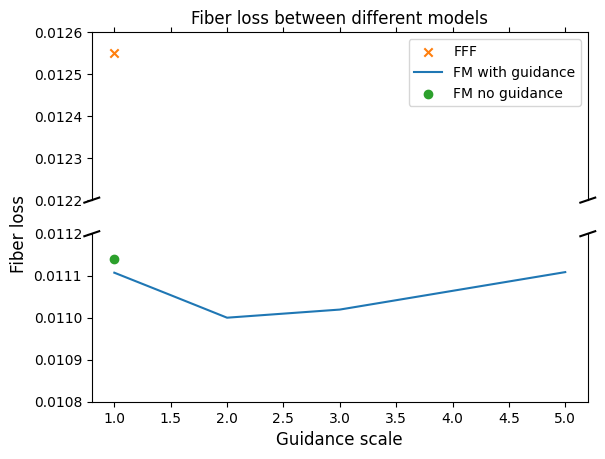

In [79]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

ax.set_ylim(0.0122, 0.0126)  
ax2.set_ylim(0.0108, 0.0112)  
ax.set_xlim(0.8, 5.2)  
ax2.set_xlim(0.8, 5.2) 
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax2.plot(scales_fm, torch.stack(fiber_losses_fm, dim=0).cpu().detach().numpy(), label="FM with guidance")
ax2.scatter([1], [fiber_loss_fm_no_guidance.cpu().detach().numpy()], marker="o", color="C2", label="FM no guidance")
ax.scatter([1], [fiber_loss_fff.cpu().detach().numpy()], marker="x", color="C1", label="FFF")
# Hidden out of plot range, for legend
ax.plot(scales_fm, torch.stack(fiber_losses_fm, dim=0).cpu().detach().numpy(), label="FM with guidance")
ax.scatter([1], [fiber_loss_fm_no_guidance.cpu().detach().numpy()], marker="o", color="C2", label="FM no guidance")
ax.set_title("Fiber loss between different models")
ax.legend()
ax2.set_xlabel("Guidance scale", fontsize=12)
ax2.set_ylabel("Fiber loss", y = 1, fontsize=12)


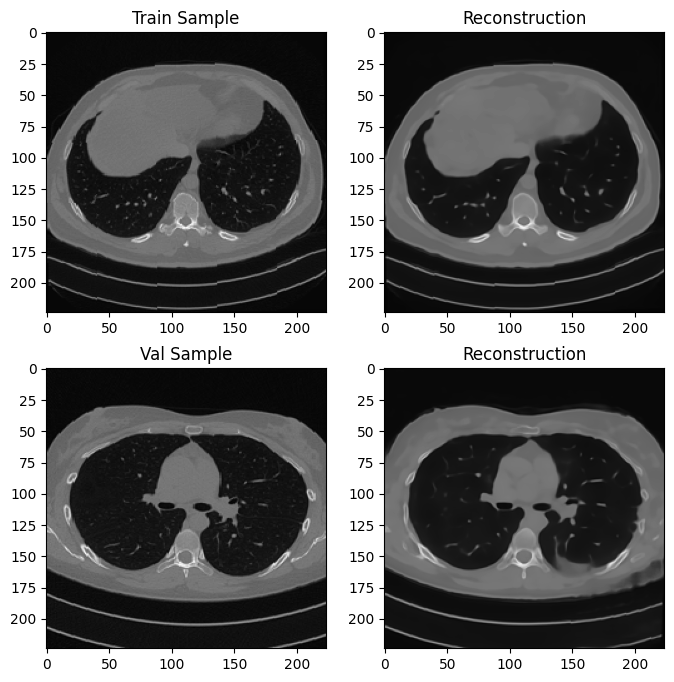

In [36]:
with torch.no_grad():
    batch = model.train_data[0]
    resolution = hparams["data_set"].get("resize_to", 128)
    batch = (batch[0].unsqueeze(0).to(device), batch[1].unsqueeze(0).to(device))
    conditioned = model.apply_conditions(batch)
    c = conditioned.condition.to(device)
    x0_train = conditioned.x0.to(device)
    x_rec_train = model(x0_train, c)
    x_rec_train = x_rec_train.squeeze(0).reshape(1, resolution, resolution)
    batch = model.val_data[0]
    resolution = hparams["data_set"].get("resize_to", 128)
    batch = (batch[0].unsqueeze(0).to(device), batch[1].unsqueeze(0).to(device))
    conditioned = model.apply_conditions(batch)
    c = conditioned.condition.to(device)
    x0_val = conditioned.x0.to(device)
    x_rec_val = model(x0_val, c)
    x_rec_val = x_rec_val.squeeze(0).reshape(1, resolution, resolution)
    plt.figure(figsize=(8,8))
    plt.subplot(2, 2, 1)
    # save color range:
    vmin = x0.min().item()
    vmax = x0.max().item()
    plt.imshow(x0_train.reshape(resolution, resolution).cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Train Sample")
    plt.subplot(2, 2, 2)
    plt.imshow(x_rec_train.squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Reconstruction")
    plt.subplot(2, 2, 3)
    plt.imshow(x0_val.reshape(resolution, resolution).cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Val Sample")
    plt.subplot(2, 2, 4)
    plt.imshow(x_rec_val.squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Reconstruction")

# Taming Transformers model

In [1]:
from taming.models.vqgan import VQModel, VQNoDiscModel
from omegaconf import OmegaConf
import torch

config_path = "/mnt/SSD_2TB/vqgan_ckpts/imagenet_16384/config.yaml"
config = OmegaConf.load(config_path)
import yaml
print(yaml.dump(OmegaConf.to_container(config)))

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/armand/miniconda3/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel



In [2]:
model = VQModel(**config.model.params)
ckpt_path = "/mnt/SSD_2TB/vqgan_ckpts/imagenet_16384/last.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)
model.eval().to(device)
pass

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/armand/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/armand/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/armand/taming-transformers/taming/modules/losses/lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/b

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [3]:
sum(p.numel() for p in model.parameters())/1e6

91.45338

torch.Size([1, 256, 14, 14])
tensor(0.9208, device='cuda:0') tensor(-0.1927, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
torch.Size([1, 3, 224, 224])


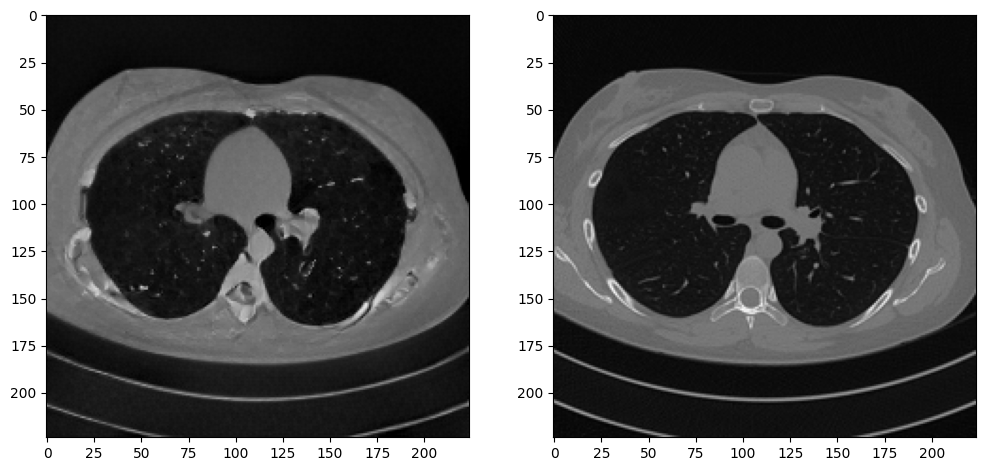

In [8]:
import matplotlib.pyplot as plt
from fff.data import load_dataset

with torch.no_grad():
    
    val_data = load_dataset(
      name="ldct",
      root="/mnt/SSD_2TB/ldct_data",
      condition="lowdose",
      data="highdose",
      patchsize=512,
      resize_to=224,
      subject_model_type="PrecompiledModel",
      subject_model_path="notebooks/SubjectModels/saved_models/BiomedClip.pt",
    )[1]
    input_im = val_data[0][0]
    input_im = input_im.reshape(-1, 1, 224, 224).to(device).repeat(1, 3, 1, 1)
    input_im = (input_im - input_im.min())/(input_im.max() - input_im.min())
    z = model.encode(input_im)[0]
    print(z.shape)
    out = model.decode(z)
    print(out.max(), out.min())
    print(input_im.max(), input_im.min())
    print(out.shape)
    vmin = input_im.min().item()
    vmax = input_im.max().item()
    plt.figure(figsize=(12,12))
    plt.subplot(1, 2, 1)
    plt.imshow(out.squeeze().mean(dim=0).cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.subplot(1, 2, 2)
    plt.imshow(input_im.squeeze().mean(dim=0).cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)

# Augmentations

In [1]:
from fff.data import load_dataset
ds = load_dataset(
    name="ldct",
    root="/mnt/SSD_2TB/ldct_data",
    condition="lowdose",
    data="highdose",
    patchsize=512,
    resize_to=224,
    augment=True,
)

INFO: Using pytorch backend
/home/armand/miniconda3/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
INFO: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


In [2]:
train_set = ds[0]

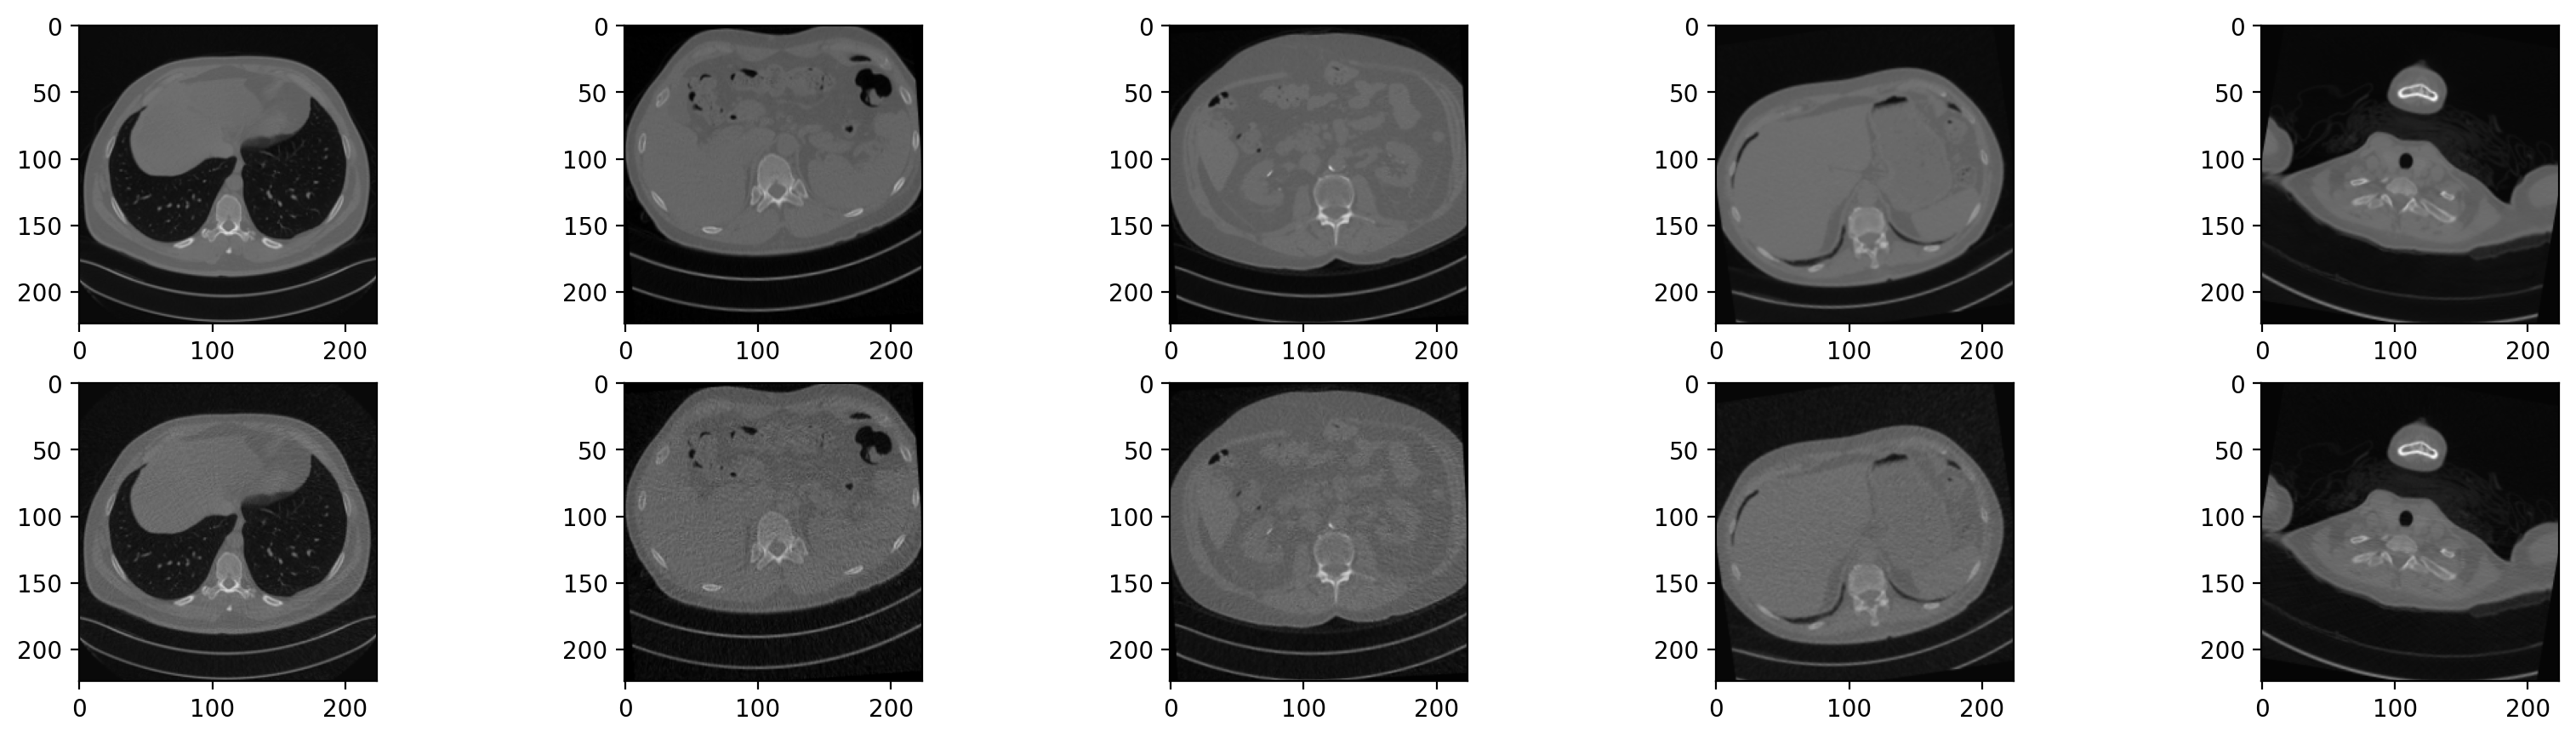

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

batch = [train_set[i] for i in range(5)]
highdose, lowdose = torch.cat([im[0] for im in batch], dim=0), torch.cat([im[1] for im in batch], dim=0)
highdose = highdose.reshape(-1, 1, 224, 224)
lowdose = lowdose.reshape(-1, 1, 224, 224)

plt.figure(figsize=(20, 5), dpi=200)
for i in range(5):
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(highdose[i].permute(1, 2, 0).cpu().numpy().squeeze(), cmap="gray", vmin=torch.min(highdose), vmax=torch.max(highdose))
    plt.subplot(2, 5, i + 6)
    plt.imshow(lowdose[i].permute(1, 2, 0).cpu().numpy().squeeze(), cmap="gray", vmin=torch.min(lowdose), vmax=torch.max(lowdose))